In [1]:
using Turing
using StatsPlots
using Optim

In [2]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")
include("lecture/plot_utils.jl");

### Dataset: World-Wide Monthly Air Passengers

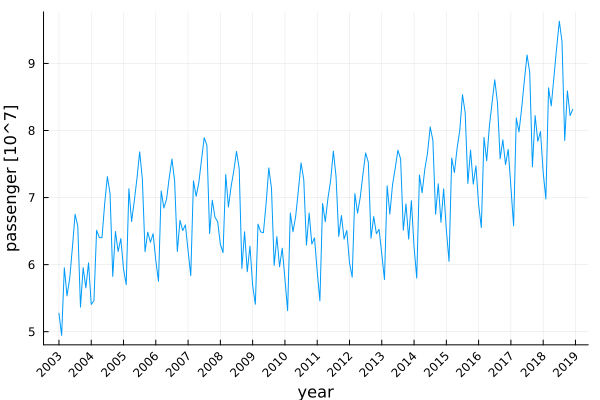

In [3]:
base_plot(air_passengers_2013_2018)

In [4]:
x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"];

In [5]:
@model function trend_model(x::Vector{Float64}, y::Vector{Float64})
    slope ~ Normal(0,3)
    intercept ~ Normal(6,3)
    error ~ InverseGamma(2,3)
    tau ~ InverseGamma(1,1)

    n_changepoints = length(y) ÷ 12
    adjustments ~ filldist(Laplace(0,tau+1e-5), n_changepoints)
    
    k = slope
    m = intercept
    j = 1
    for i in eachindex(y)
        if i % 12 == 1
            k += adjustments[j]
            m -= (x[i] - x[1]) * adjustments[j]
            j += 1
        end
        y[i] ~ Normal(k * (x[i] - x[1]) + m, error+1e-5)
    end
end

trend_model (generic function with 2 methods)

In [6]:
res = optimize(trend_model(x, y), MAP(), Optim.Options(iterations=10_000))

ModeResult with maximized lp of -164.93
[0.27343641822337783, 5.895943454822323, 0.6012502555022375, 0.08980430377292475, -8.969495798367518e-17, -1.210257518982117e-16, -0.022602823811247515, -0.22616926329059148, -0.050530582074999, -4.7767352779783004e-18, 1.66543182652676e-17, 0.029356525919005567, 0.07298244043523364, 0.013648275872448521, 0.1111224467197285, 0.10633152337828376, 5.842751763372657e-5, 6.500138185036196e-17, 3.306584039311933e-16, -9.634045622870482e-17]

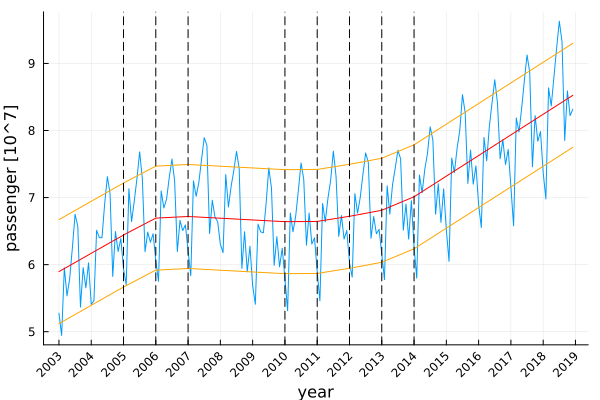

In [7]:
map_vector = res.values.array;
plot_trend_model_3(air_passengers_2013_2018, map_vector)

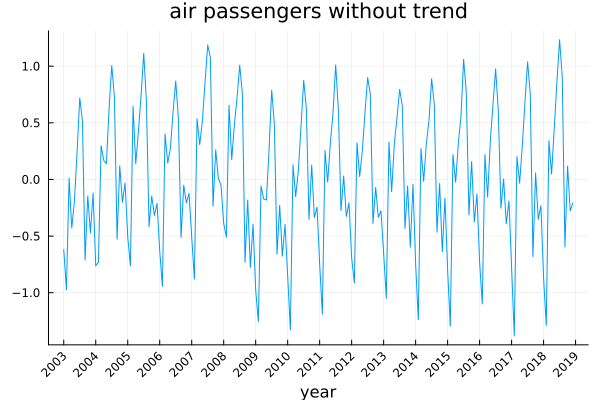

In [8]:
map_vector = res.values.array

t_min = x[1]
changepoints = x[(1:length(x)) .% 12 .== 1] .- x[1]
slope, intercept, error, adjustments = map_vector[1], map_vector[2], map_vector[3], map_vector[5:end]

# substract the trend model from the data
y_stationary =  y .- map(t -> trend_model_3_f(t - t_min, slope, intercept, changepoints, adjustments), x)

base_plot((x, y_stationary))
title!("air passengers without trend")
ylabel!("")

In [9]:
function seasonality_component(t::Float64, N_frequencies::Int, beta::Vector{<:Real})
    s = 0
    for n in 1:N_frequencies
        s += beta[2*n-1] * sin(2*pi*n*t)
        s += beta[2*n] * cos(2*pi*n*t)
    end
    return s
end

@model function seasonality_model(x::Vector{Float64}, y::Vector{Float64}, N_frequencies::Int)
    beta ~ filldist(Normal(0,1.), 2*N_frequencies)
    error ~ InverseGamma(2,3)
    
    for i in eachindex(y)
        t = x[i] - x[1]
        s = seasonality_component(t, N_frequencies, beta)
        y[i] ~ Normal(s, error+1e-5)
    end

end

seasonality_model (generic function with 2 methods)

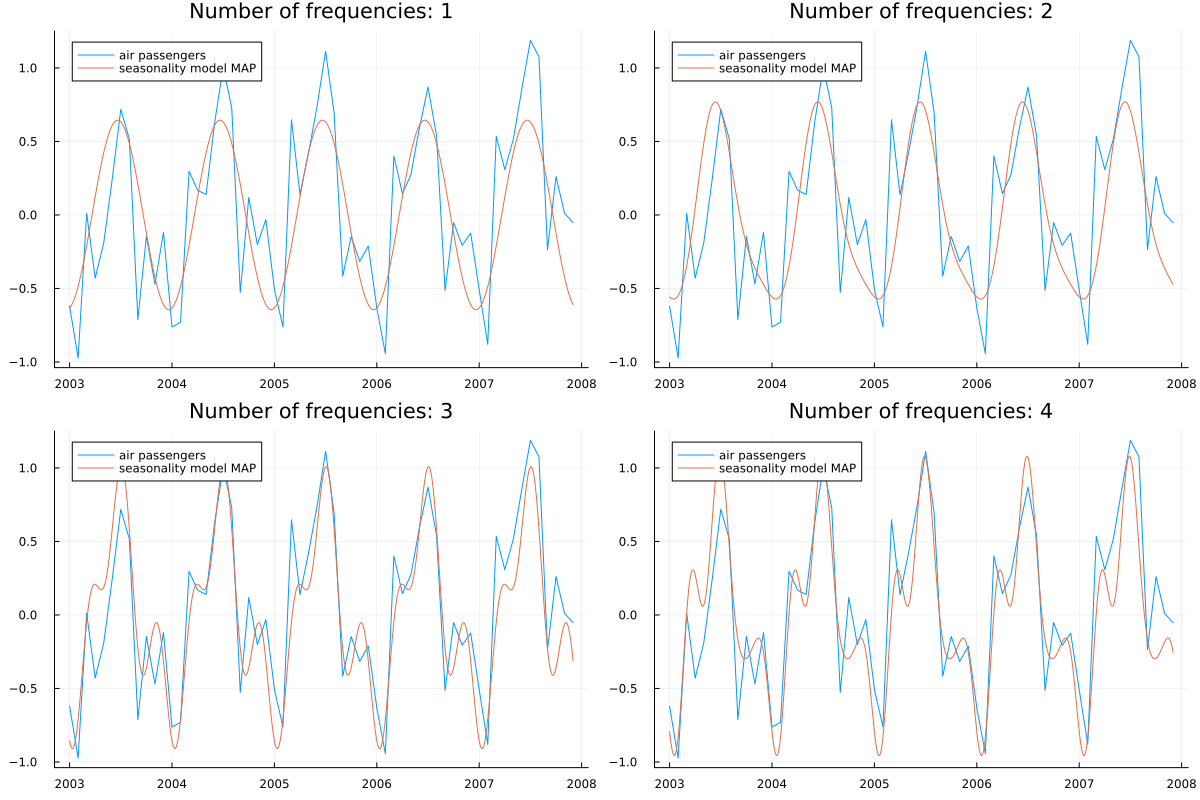

In [10]:
ps = []
for N_frequencies in 1:4
    res_seasonal = optimize(seasonality_model(x, y_stationary, N_frequencies), MAP())
    beta = res_seasonal.values.array

    mask = 1:60
    p = plot(x[mask], y_stationary[mask], label="air passengers", legend=:topleft, title="Number of frequencies: $N_frequencies")
    plot!(t -> seasonality_component(t, N_frequencies, beta), label="seasonality model MAP")
    push!(ps, p)
end
plot(ps...,layout=(2,2), size=(1200,800))

In [ ]:
N_frequencies = 3 # seems to be a good choice